# S&P 500 Classfication Models

In this project I will go over multiple classification algorithms in an attempt to find suitable models for market forecasting. More specifically, SPDR S&P 500 Trust ETF (SPY) is picked as a convenient way to analyze the S&P 500. Many other related datasets will also be used, such as sector ETFs, foreign exchange rates, commodity futures, and economic data. 

A big focus on this project will also feature selection. I want to use this project to gain some hands-on experience on implementing different feature selection methods and learn how to apply them optimally.

I will also cover areas such as data preprocessing, feature engineering, hyper-parameter optimization, and model selection. 

Author: Eric Tang

Date: 2020-05-03

## Initialization

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import quandl
import pyfolio as pf

#Split
from sklearn.model_selection import train_test_split,TimeSeriesSplit,GridSearchCV
#Feature selection / dimension reduction
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFECV,SelectPercentile,mutual_info_classif
#Performance evaluation
from sklearn import metrics

# Classifiers
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import RidgeClassifier, SGDClassifier, LogisticRegression,PassiveAggressiveClassifier
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier

import warnings
warnings.filterwarnings('ignore')

quandl.ApiConfig.api_key = "WLMxat9y7vVtegz9ZEe5"
start = '2000-01-01'
end = '2020-04-30'

np.random.seed(seed=1)

## Datasets
This section consists of three dictionaries, each represent a group of data we will retrieve later in this notebook.

### Group 1:
This group of time series data all share similar characteristics as they are updated every business day. Very low data preprocessing techniques are needed. I chose multiple commodity futures, major foreign exchange pairs, different treasury related data in order to include the daily macro effects around the world.

In [67]:
#Daily data from Quandl
quandl_dict= {
    #futures
    'gold' :"CHRIS/CME_GC1.4", #Gold Futures, Continuous Contract #1 (GC1) (Front Month)
    'eurodollar': "CHRIS/CME_ED1.4", #Eurodollar Futures, Continuous Contract #1 (ED1) (Front Month)
    'silver': "CHRIS/CME_SI1.4", #Silver Futures, Continuous Contract #1 (SI1) (Front Month)
    'DCOILWTICO': "FRED/DCOILWTICO.4", #Crude Oil Prices: West Texas Intermediate (WTI) - Cushing, Oklahoma
    #major currency pair spot rates
    'USDCAD': "FED/RXI_N_B_CA", #CANADA -- SPOT EXCHANGE RATE, CANADIAN $/US$, Business day
    'EURUSD': "FED/RXI_US_N_B_EU", #SPOT EXCHANGE RATE - EURO AREA, Business day
    'GBPUSD': "FED/RXI_US_N_B_UK", #UNITED KINGDOM -- SPOT EXCHANGE RATE, US$/POUND (1/RXI_N.B.UK), Business day
    'USDJPY': "FED/RXI_N_B_JA", #JAPAN -- SPOT EXCHANGE RATE, YEN/US$, Business day
    'AUDUSD': "FED/RXI_US_N_B_AL", #AUSTRALIA -- SPOT EXCHANGE RATE US$/AU$ (RECIPROCAL OF RXI_N.B.AL), Business day
    'NZDUSD': "FED/RXI_US_N_B_NZ", #NEW ZEALAND -- SPOT EXCHANGE RATE, US$/NZ$ RECIPROCAL OF RXI_N.B.NZ, Business day
    'USDCHF': "FED/RXI_N_B_SZ", #SWITZERLAND -- SPOT EXCHANGE RATE, FRANCS/US$, Business day
    'USDNOK': "FED/RXI_N_B_NO", #NORWAY -- SPOT EXCHANGE RATE, KRONER/US$, Business day
    'USDCNY': "FED/RXI_N_B_CH", #CHINA -- SPOT EXCHANGE RATE, YUAN/US$ P.R., Business day
    'USDINR': "FED/RXI_N_B_IN", #INDIA -- SPOT EXCHANGE RATE, RUPEES/US$, Business day
    'DTWEXM': "FRED/DTWEXM", #Trade Weighted U.S. Dollar Index: Major Currencies
    'DTWEXB': "FRED/DTWEXB", #Trade Weighted U.S. Dollar Index: Broad
    #Interest rates
    'DFF': "FRED/DFF", #Effective Federal Funds Rate
    'DTB3': "FRED/DTB3", #3-Month Treasury Bill: Secondary Market Rate
    'DGS5': "FRED/DGS5", #5-Year Treasury Constant Maturity Rate
    'DGS10': "FRED/DGS10",#10-Year Treasury Constant Maturity Rate
    'DGS30': "FRED/DGS30", #30-Year Treasury Constant Maturity Rate
    'T5YIE': "FRED/T5YIE", #5-year Breakeven Inflation Rate
    'T10YIE': "FRED/T10YIE", #10-year Breakeven Inflation Rate
    'T5YIFR': "FRED/T5YIFR",#5-Year, 5-Year Forward Inflation Expectation Rate 
    'TEDRATE': "FRED/TEDRATE", #TED Spread
    'DPRIME': "FRED/DPRIME" #Bank Prime Loan Rate
}

### Group 2:
While the previous data represents the external macro relationships surrounding the equity market. This group of data represents the internal interactive effects within the U.S. equity market. The VIX index (also known as the fear index) is included to measure the “mood” of the market participants. ETFs that represent different industries are included with a goal to include the effect of different business cycles.

In [68]:
#Local files (Source: yahoo finance)
local_files = {
    'VIX':"https://raw.githubusercontent.com/YizhouTang/SP500_Classfication_Models/master/data/VIX.csv", #Vix index
    #Sector ETFs:
    'XLE':"https://raw.githubusercontent.com/YizhouTang/SP500_Classfication_Models/master/data/XLE.csv", #Energy Select Sector SPDR Fund 
    'XLF':"https://raw.githubusercontent.com/YizhouTang/SP500_Classfication_Models/master/data/XLF.csv", #Financial Select Sector SPDR Fund
    'XLU':"https://raw.githubusercontent.com/YizhouTang/SP500_Classfication_Models/master/data/XLU.csv", #Utilities Select Sector SPDR Fund
    'XLI':"https://raw.githubusercontent.com/YizhouTang/SP500_Classfication_Models/master/data/XLI.csv", #Industrial Select Sector SPDR Fund
    'XLK':"https://raw.githubusercontent.com/YizhouTang/SP500_Classfication_Models/master/data/XLK.csv", #Technology Select Sector SPDR Fund
    'XLV':"https://raw.githubusercontent.com/YizhouTang/SP500_Classfication_Models/master/data/XLV.csv", #Health Care Select Sector SPDR Fund
    'XLY':"https://raw.githubusercontent.com/YizhouTang/SP500_Classfication_Models/master/data/XLY.csv", #Consumer Discretionary Select Sector SPDR Fund
    'XLP':"https://raw.githubusercontent.com/YizhouTang/SP500_Classfication_Models/master/data/XLP.csv", #Consumer Staples Select Sector SPDR Fund
    'XLB':"https://raw.githubusercontent.com/YizhouTang/SP500_Classfication_Models/master/data/XLB.csv", #Materials Select Sector SPDR Fund
}

### Group 3:
The previous two groups allow the models to have an idea of what is happening on a daily basis due to the high frequency of the data. However, in order to measure the financial market, it is also important to look at the lower frequency economic and fundamental data. This group includes lower frequency data that are released on a monthly/quarterly basis, hence data preprocessing techniques such as forward fill will be needed. The economic indices are chosen in order to
cover the different areas such as growth, inflation, employment, income and expenditure, and debt. The fundamental data includes selected financial ratios from the S&P 500 Ratios dataset provided by Quandl.


In [69]:
#econ features that are not daily (weekly, monthly & quarterly data - need to ffill)
sparse_econ_data= {
    #Growth
    'GDP' :"FRED/GDPPOT", #Gross Domestic Product
    'GDPC1': "FRED/GDPC1", #Real Gross Domestic Product
    'GDPPOT': "FRED/GDPC1", #Real Potential Gross Domestic Product
    #Prices and Inflation
    'CPIAUCSL': "FRED/CPIAUCSL", #Consumer Price Index for All Urban Consumers: All Items
    'CPILFESL': "FRED/CPILFESL", #Consumer Price Index for All Urban Consumers: All Items Less Food & Energy
    'GDPDEF': "FRED/GDPDEF", #Gross Domestic Product: Implicit Price Deflator
    #Money Supply
    'BASE': "FRED/BASE", #St. Louis Adjusted Monetary Base
    'M1': "FRED/M1", #M1 Money Stock
    'M2': "FRED/M2", #M2 Money Stock
    'M1V': "FRED/M1V", #Velocity of M1 Money Stock
    'M2V': "FRED/M2V", #Velocity of M2 Money Stock
    #Employment
    'UNRATE': "FRED/UNRATE", #Civilian Unemployment Rate
    'NROU': "FRED/NROU", #Natural Rate of Unemployment (Long-Term)
    'NROUST': "FRED/NROUST", #Natural Rate of Unemployment (Short-Term)
    'CIVPART': "FRED/CIVPART", #Civilian Labor Force Participation Rate
    'EMRATIO': "FRED/EMRATIO", #Civilian Employment-Population Ratio
    'UNEMPLOY': "FRED/UNEMPLOY", #Unemployed level
    'PAYEMS': "FRED/PAYEMS", #All Employees: Total nonfarm
    'MANEMP': "FRED/MANEMP", #All Employees: Manufacturing
    'ICSA': "FRED/ICSA", #Initial Claims
    #Income and Expenditure
    'MEHOINUSA672N': "FRED/MEHOINUSA672N", #Real Median Household Income in the United States
    'DSPIC96': "FRED/DSPIC96", #Real Disposable Personal Income
    'PCE': "FRED/PCE", #Personal Consumption Expenditures
    'PCEDG': "FRED/PCEDG", #Personal Consumption Expenditures: Durable Goods
    'PSAVERT': "FRED/PSAVERT", #Personal Saving Rate
    'RRSFS': "FRED/RRSFS", #Real Retail and Food Services Sales
    'DSPI': "FRED/DSPI", #Disposable personal income
    #Debt
    'GFDEBTN': "FRED/GFDEBTN", #Federal Debt: Total Public Debt
    'GFDEGDQ188S': "FRED/GFDEGDQ188S", #Federal Debt: Total Public Debt as Percent of Gross Domestic Product
    'EXCSRESNW': "FRED/EXCSRESNW", #Excess Reserves of Depository Institutions
    'TOTCI': "FRED/TOTCI", #Commercial and Industrial Loans, All Commercial Banks
    #Other Economic Indicators
    'INDPRO': "FRED/INDPRO", #Industrial Production Index
    'TCU': "FRED/TCU", #Capacity Utilization: Total Industry
    'HOUST': "FRED/HOUST", #Housing Starts: Total: New Privately Owned Housing Units Started
    'GPDI': "FRED/GPDI", #Gross Private Domestic Investment
    'CP': "FRED/CP", #Corporate Profits After Tax (without IVA and CCAdj)
    'STLFSI': "FRED/STLFSI", #St. Louis Fed Financial Stress Index
    'USSLIND': "FRED/USSLIND", #Leading Index for the United States
    'S&P 500 Dividend Yield by Month': "MULTPL/SP500_DIV_MONTH",#12-month real dividend per share inflation adjusted February, 2020 dollars. Data courtesy Standard & Poor's and Robert Shiller.
    'S&P 500 Earnings by Month':"MULTPL/SP500_EARNINGS_MONTH",#S&P 500 Earnings Per Share. 12-month real earnings per share inflation adjusted, constant February, 2020 dollars. Sources: Standard & Poor's for current S&P 500 Earnings. Robert Shiller and his book Irrational Exuberance for historic S&P 500 Earnings.
    'S&P 500 Earnings Yield by Month':"MULTPL/SP500_EARNINGS_YIELD_MONTH",#S&P 500 Earnings Yield. Earnings Yield = trailing 12 month earnings divided by index price (or inverse PE) Yields following September, 2019 (including current yield) are estimated based on 12 month earnings through September, 2019 the latest reported by S&P. Source: Standard & Poor's
    'S&P 500 PE Ratio by Month':"MULTPL/SP500_PE_RATIO_MONTH",#Price to earnings ratio, based on trailing twelve month as reported earnings. Current PE is estimated from latest reported earnings and current market price. Source: Robert Shiller and his book Irrational Exuberance for historic S&P 500 PE Ratio.
}


## Construct Target Variable

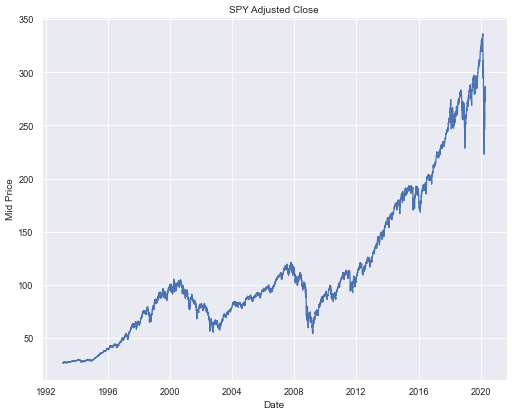

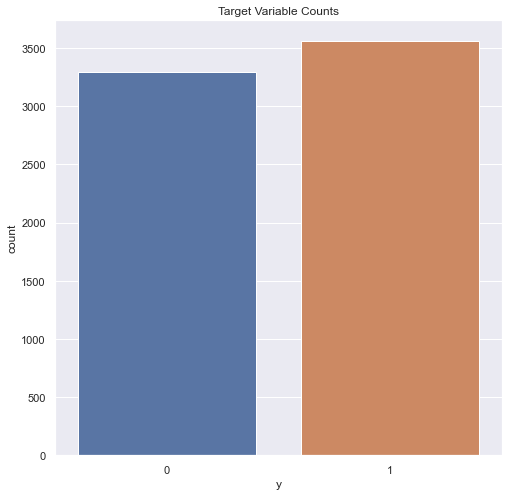

In [70]:
# Import SPY
url = "https://raw.githubusercontent.com/YizhouTang/SP500_Classfication_Models/master/data/SPY.csv"

#df = pd.read_csv('SPY.csv',index_col = 'Date',parse_dates = True)
df = pd.read_csv(url,index_col = 'Date',parse_dates = True)

#Visualization
plt.figure(figsize=(10, 8), dpi= 60)
plt.title("SPY Adjusted Close")
plt.plot(df['Adj Close'])
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.show()

#Shift -1 for next day's return
#Classification
df['SPY_forward_ret'] = df['Close'].shift(-1)/df['Open'].shift(-1) -1

#If tomorrow's return > 0, then 1
#If tomorrow's return <= 0, then 0
df['y'] = 0
df.at[df['SPY_forward_ret'] > 0.0,'y'] = 1

#Remove it make sure no look ahead bias
del df['SPY_forward_ret']

#plot y
plt.figure(figsize=(8, 8))
sns.countplot('y', data=df)
plt.title('Target Variable Counts')
plt.show()

## Construct Features 
This section mainly consits of the helper functions for me to import the local files and datasets from quandl. Each helper function is created specifically for one of the three datasets. I also wrote an additional feature engineering function to compute additional features from existing ones.

### Helper Functions

In [71]:
#Function to get data from Quandl.
def get_quandl_data(df,quandl_dict,start,end):
    data = quandl.get(list(quandl_dict.values()), start_date=start, end_date=end)
    data.columns = list(quandl_dict.keys())
    df = pd.concat([df, data.reindex(df.index)], axis=1)
    return df

#Function to get data from Quandl.
def get_local_data(df,local_files,start,end):
    for i in local_files:
        url = local_files[i]
        df_temp = pd.read_csv(url,index_col='Date',parse_dates = True)
        df_temp = df_temp['Adj Close'].to_frame()
        df_temp.columns = [i]
        df = pd.concat([df, df_temp.reindex(df.index)], axis=1)

    mask = (df.index>=pd.to_datetime(start)) & (df.index <=pd.to_datetime(end))
    df = df.loc[mask]
    return df

#Function to get sparse econ data (frequence != daily) from Quandl.
#Also compute the change in economic data.
#All econ data are preproccessed using ffill.
def get_sparse_econ_data(df,econ_dict,start,end):
    #Get raw econ data
    data = quandl.get(list(econ_dict.values()), start_date=start, end_date=end)
    data.columns = list(econ_dict.keys())
    #Get econ data, transformed using percentage return
    ret_data = quandl.get(list(econ_dict.values()), start_date=start, end_date=end,transform = "rdiff")
    ret_data.columns = [col + '_ret' for col in list(econ_dict.keys())]

    data = data.ffill()
    data = data.reindex(df.index)
    data = data.ffill()

    ret_data = ret_data.ffill()
    ret_data = ret_data.reindex(df.index)
    ret_data = ret_data.ffill()

    df = pd.concat([df,data ,ret_data], axis=1)

    return df

### Feature Engineering

In [72]:
#Function to compute additional derived features
#It iterates through each existing feature and compute key statistics (rolling) for multiple lookback periods.
def derive_features(df):
    features = df.columns
    #Iterate through each column in df
    for col in features:
        if col != 'y':
            #Daily change
            df[col+'_ret'] = df[col].pct_change()
            df[col+'_diff'] = df[col].diff()
            #Lookback periods
            lookback = [5,21, 63, 126, 252]#1 week, 1 month, 1 quarter, half year, 1 year
            
            #Compute key statistics for each lookback period
            for i in lookback:
                df[col+'_ret_' + str(i)] = df[col]/df[col].shift(i)-1
                #Return-based
                df[col+'_rolling_mean_' + str(i)] = df[col+'_ret'].rolling(i).mean()
                df[col+'_rolling_median_' + str(i)] = df[col+'_ret'].rolling(i).median()
                df[col+'_rolling_stdev_' + str(i)] = df[col+'_ret'].rolling(i).std()
                df[col+ '_rolling_skew_' + str(i)] = df[col+'_ret'].rolling(i).skew()
                df[col+ '_rolling_kurt_' + str(i)] = df[col+'_ret'].rolling(i).kurt()
                df[col+ '_rolling_min_' + str(i)] = df[col+'_ret'].rolling(i).min()
                df[col+ '_rolling_max_' + str(i)] = df[col+'_ret'].rolling(i).max()
                df[col+ '_rolling_corr_' + str(i)] = df[col+'_ret'].rolling(i).corr()
                df[col+ '_ewma_' + str(i)] = pd.DataFrame.ewm(df[col], span= i).mean()
                #Relative level
                df[col+'_rel_lvl_mean_' + str(i)] = df[col]/df[col].rolling(i).mean()
                df[col+'_rel_lvl_min_' + str(i)] = df[col]/df[col].rolling(i).min()
                df[col+'_rel_lvl_max_' + str(i)] = df[col]/df[col].rolling(i).max()                        
    return df

In [73]:
# Import daily frequency data.
df = get_quandl_data(df,quandl_dict,start,end)
df = get_local_data(df,local_files,start,end)

# Compute additional derived features.
df = derive_features(df)  

# Import economic data from Quandl.
# I did not call the derive_features function for the economic data due to the low frequency nature of the data.
df = get_sparse_econ_data(df,sparse_econ_data,start,end)

## Data Preprocessing
With the three groups of data and additional derived features, we have quite a large number of features, however many of them include a lot of NaN values. This section removes the columns that have more than 1% of missing values from our features.

In [74]:
#set timezone
df = df.tz_localize(tz='US/Eastern')

#rmissingvaluecol is a helper function that removes columns that have nans more than the threshold percentage
def rmissingvaluecol(df,threshold):
    l = []
    l = list(df.drop(df.loc[:,list((100*(df.isnull().sum()/len(df.index))>=threshold))].columns, 1).columns.values)
    print("# Columns having more than %s percent missing values:"%threshold,(df.shape[1] - len(l)))
    return l

df = df.replace([np.inf, -np.inf], np.nan)

cols = rmissingvaluecol(df,1) #Here threshold is 1% which means we are going to drop columns having more than 1% of missing values

df_dropped_na= df[cols]

df_dropped_na = df_dropped_na.dropna()

# Columns having more than 1 percent missing values: 1901


## Train/Test Split

In [75]:
#Split data set
X = df_dropped_na.loc[:, df_dropped_na.columns != 'y']
y = df_dropped_na.loc[:, df_dropped_na.columns == 'y']

#Test set uses 20% of the data, no shuffle since we're dealing with time series.
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=False)

#Summary
print("Train/Test Split Results:")
print("X Train Set:")
print(X_train_raw.shape)
print("X Test Set:")
print(X_test_raw.shape)

Train/Test Split Results:
X Train Set:
(3984, 1039)
X Test Set:
(996, 1039)


In [158]:
X_test_raw.tail()

,Open,High,Low,Close,Adj Close,Volume,eurodollar,USDCAD,EURUSD,GBPUSD,...,TOTCI_ret,INDPRO_ret,TCU_ret,HOUST_ret,STLFSI_ret,USSLIND_ret,S&P 500 Dividend Yield by Month_ret,S&P 500 Earnings by Month_ret,S&P 500 Earnings Yield by Month_ret,S&P 500 PE Ratio by Month_ret
Date,,,,,,,,,,,,,,,,,,,,,
2020-04-16 00:00:00-04:00,279.149994,280.029999,275.760010,279.100006,279.100006,131798300,99.540,1.4141,1.0840,1.2433,...,0.010001,-0.054009,-0.05503,-0.222506,-0.92569,0.095541,0.009659,0.016913,-0.01751,0.017995
2020-04-17 00:00:00-04:00,285.380005,287.299988,282.399994,286.640015,286.640015,146684800,99.550,1.4026,1.0883,1.2503,...,0.010001,-0.054009,-0.05503,-0.222506,-0.92569,0.095541,0.009659,0.016913,-0.01751,0.017995
2020-04-20 00:00:00-04:00,282.609985,286.790009,281.350006,281.589996,281.589996,100109300,99.510,1.4067,1.0874,1.2467,...,0.010001,-0.054009,-0.05503,-0.222506,-0.92569,0.095541,0.009659,0.016913,-0.01751,0.017995
2020-04-21 00:00:00-04:00,276.730011,278.040009,272.019989,273.040009,273.040009,126385700,99.525,1.4199,1.0854,1.2266,...,0.010001,-0.054009,-0.05503,-0.222506,-0.92569,0.095541,0.009659,0.016913,-0.01751,0.017995
2020-04-22 00:00:00-04:00,278.350006,281.000000,276.910004,279.100006,279.100006,93524600,99.545,1.4132,1.0829,1.2332,...,0.034264,-0.054009,-0.05503,-0.222506,-0.92569,0.095541,0.009659,0.016913,-0.01751,0.017995


## Standardization
Standardize features by removing the mean and scaling to unit variance.

In [76]:
#Initialize and fit scaler
scaler = StandardScaler()
#Fit scaler using the training data
scaler.fit(X_train_raw)

#Transform the raw data
X_train_standardized = scaler.transform(X_train_raw)
X_test_standardized = scaler.transform(X_test_raw)

## Univariate Feature Selection¶
Because we currently have a very large number of features, I decided to use univariate feature selection first to "weed out" a group of features first, instead of running a computationally expensive method like RFECV directly,

Due to the non-linear nature of financial data, mutual information is used as opposed to the F-test. The F-test estimates the degree of linear dependency between two random variables. On the other hand, mutual information methods can capture any kind of statistical dependency, but being nonparametric, they require more samples for accurate estimation.

Mutual information (MI) between two random variables is a non-negative value, which measures the dependency between the variables. It is equal to zero if and only if two random variables are independent, and higher values mean higher dependency.

In [77]:
#Initialize and fit selector
MI_selector = SelectPercentile(mutual_info_classif, percentile=60)#Remove the lower 40%
MI_selector.fit(X_train_standardized,  y_train.values.ravel())

#Transform
X_train_MI = MI_selector.transform(X_train_standardized)
X_test_MI = MI_selector.transform(X_test_standardized)

#Summary
print("Feature Selection Results - Univariate Feature Selection")
#Summary
print("Filter Result:")
print("Number of features: ",X_train_MI.shape[1])

Feature Selection Results - Univariate Feature Selection
Filter Result:
Number of features:  623


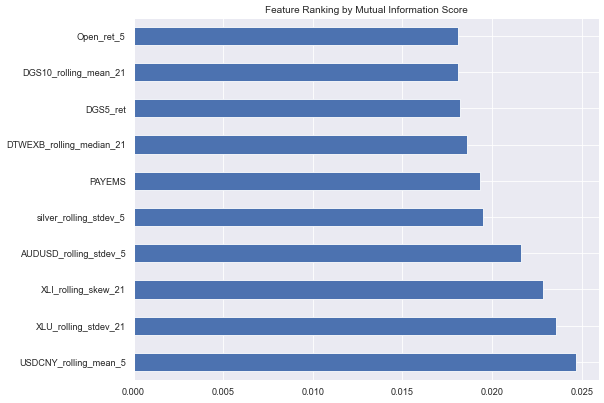

In [78]:
#Rank the features by scores
plt.figure(figsize=(10, 8), dpi= 60)
feat_scores = pd.Series(MI_selector.scores_, index=X_train_raw.columns)
top_feat = feat_scores.nlargest(10)
top_feat.plot(kind='barh')
plt.title("Feature Ranking by Mutual Information Score")
plt.show()

## Correlation-Based Feature Selection¶
The univariate feature selection method allows us to get rid of the variables that have a low dependency with our y variable, however as the name suggests, it does not take into account potential issues such as collinearity.
In this section, I will filter out the highly correlated features to further reduce the dimension of our features.

Correlation Filter Result:
Number of features:  462


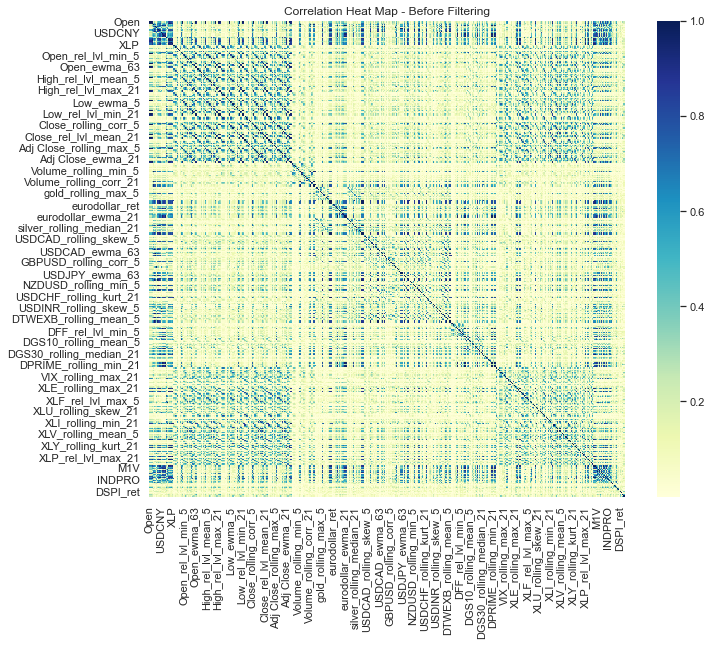

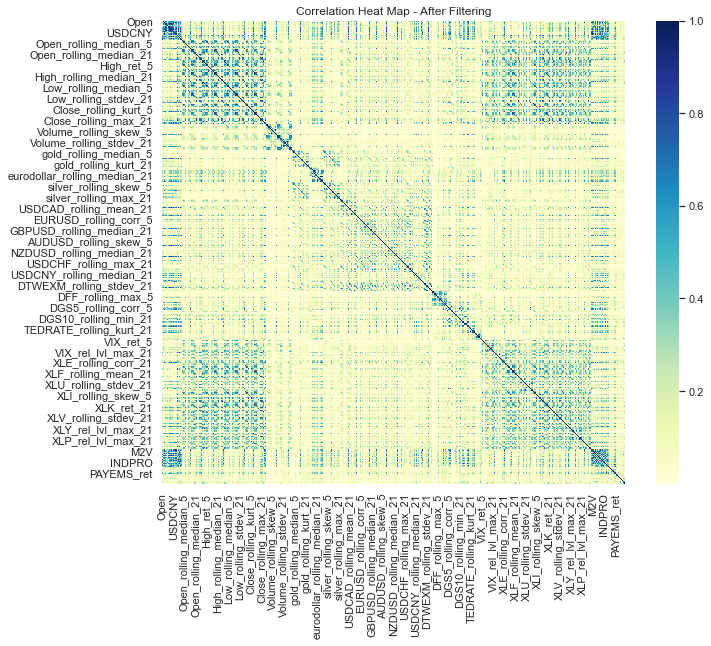

In [79]:
#Function to filter features based on correlation
#X_train and X_test inputs must be dataframes
#Corr_threshold is the cuttoff level for correlation coefficient
def correlation_filter(X_train,X_test,corr_threshold):
    
    #Compute correlation matrix
    corr_matrix = X_train.corr(method = "spearman").abs()
    
    # Select upper triangle of matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k = 1).astype(np.bool))
    
    # Find index of feature columns with correlation greater than user-defined threshold
    to_drop = [column for column in upper.columns if any(upper[column] > corr_threshold)]
    
    # Drop features
    X_train_corr_filtered = X_train.drop(to_drop, axis = 1)
    X_test_corr_filtered = X_test.drop(to_drop, axis = 1)
    
    return X_train_corr_filtered, X_test_corr_filtered

#Helper function for heat map
def heat_map(corr_matrix,title):
    
    sns.set(font_scale = 1.0)
    f, ax = plt.subplots(figsize=(11, 9))
    sns.heatmap(corr_matrix, cmap= "YlGnBu", square=True, ax = ax)
    f.tight_layout()
    ax.set_title(title)

#Initialize dataframes
df_train_MI = pd.DataFrame(data = X_train_MI,
                       index = X_train_raw.index,
                       columns = X_train_raw.columns[MI_selector.get_support()])

df_test_MI = pd.DataFrame(data = X_test_MI,
                       index = X_test_raw.index,
                       columns = X_test_raw.columns[MI_selector.get_support()])

#Filter
X_train_corr, X_test_corr = correlation_filter(df_train_MI,df_test_MI,0.95)

#Correlation heatmap before/after removing highly correlated features (training set)
corr_matrix_before = df_train_MI.corr(method = "spearman").abs()
corr_matrix_after = X_train_corr.corr(method = "spearman").abs()

#Plot heatmaps
heat_map(corr_matrix_before, "Correlation Heat Map - Before Filtering")
heat_map(corr_matrix_after, "Correlation Heat Map - After Filtering")

#Summary
print("Correlation Filter Result:")
print("Number of features: ",X_train_corr.shape[1])

## Helper Functions: Recursive Feature Elimination and Cross-Validation

After using two filtering methods (mutual information and correlation), the next step is to a wrapper method RFECV for each individual classifier. The RFECV function uses recursive feature elimination for a user-defined base estimator to rank the features and use cross-validation to select the best number of features.

In [80]:
# Plot number of features VS. cross-validation scores
def rfecv_analysis_viz(rfecv):
    plt.figure()
    plt.xlabel("Number of features selected")
    plt.ylabel("Cross validation score")
    plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
    plt.hlines(y=rfecv.grid_scores_.max(), xmin=0, xmax=rfecv.n_features_, colors='r', linestyles='--', lw=2)
    plt.show()
    
    print("Number of features selected by RFECV")
    print(rfecv.n_features_)

In [81]:
def feature_importance_viz(rfecv,X_train_corr,X_train_RFECV, top = 5):
    try:
        importances = rfecv.estimator_.feature_importances_
    except:
        importances = abs(rfecv.estimator_.coef_[0])
    
    indices = np.argsort(importances)[::-1]

    #Initialize dataframes
    df_X_train_RFECV = pd.DataFrame(data = X_train_RFECV,
                           index = X_train_corr.index,
                           columns = X_train_corr.columns[rfecv.get_support()])
    
    # Print the feature ranking
    print("Feature ranking and their importances:")
    # Plot the top features
    plt.figure(figsize=(10, 8), dpi= 60)
    #plot graph of feature importances for better visualization
    feat_importances = pd.Series(importances, index=df_X_train_RFECV.columns)
    feat_importances.nlargest(top).plot(kind='barh')
    plt.title("Feature Importances Ranking")
    plt.show()

## Helper Functions: Dimension Reduction - PCA
After getting the best subset of features with RFECV, PCA will be applied to further reduce the dimension of our selected features. To preserve the most amount of information, we keep the number of components that can explain at least 99% of the total variance.

In [191]:
def pca_component_viz(pca,X_train_PCA,top = 5):
    cols = []
    for i in range(1,min(top,pca.n_components_)+1):
        cols.append('PC'+str(i))

    #Scree plot
    scree = pd.DataFrame({'var':pca.explained_variance_ratio_[0:min(top,pca.n_components_)],
                 'PC':cols})
    plt.figure(figsize=(10, 8), dpi= 60)
    sns.barplot(x='PC',y="var", 
               data=scree);

    #The first two principal components
    plt.figure(figsize=(10, 8), dpi= 60)
    plt.scatter(X_train_PCA[:, 0], X_train_PCA[:, 1],
                c=y_train['y'], edgecolor='none', alpha=0.5,
                cmap=plt.cm.get_cmap('bwr', 2))
    plt.xlabel('component 1')
    plt.ylabel('component 2')
    plt.title("Top 2 Principal Components")
    plt.colorbar();
    
    print("Number of principal components selected by PCA")
    print(pca.n_components_)

## Classification Models
After applying multiple feature selection & dimension reduction to our data, the last step will be model selection section. The cell below represents the list of different classification models that are included in this research. We will compare different families of classification models from traditional linear models to more sophisticated ensemble-based models. The goal is to evaluate their performances in both in-sample and out-of-sample.

In [84]:
# Create list of tuples with classifier label and classifier object
classifiers = {}
#Linear models
classifiers.update({"PAC": PassiveAggressiveClassifier(n_jobs = -1)})
classifiers.update({"Ridge": RidgeClassifier()})
classifiers.update({"SGD": SGDClassifier(n_jobs = -1)})
classifiers.update({"Logistic Regression":LogisticRegression(solver = "saga",n_jobs = -1)})
classifiers.update({"LDA": LinearDiscriminantAnalysis()})
#Tree models
classifiers.update({"Random Forest": RandomForestClassifier(n_jobs = -1)})
classifiers.update({"DTC": DecisionTreeClassifier()})
classifiers.update({"ETC": ExtraTreeClassifier()})
classifiers.update({"AdaBoost": AdaBoostClassifier()})
classifiers.update({"Extra Trees Ensemble": ExtraTreesClassifier(n_jobs = -1)})
classifiers.update({"Gradient Boosting": GradientBoostingClassifier()})

classifiers.update({"LSVC": LinearSVC()})

## Hyper-parameter Optimization
This section lists the different parameters for each model in our dictionary above.

In [85]:
# Initiate parameter grid
parameters = {}

# Update dict with Passive Aggresive Classifier
parameters.update({"PAC": {"C": [0.0001, 0.001, 0.01, 0.1, 1.0, 10, 100],
                           "max_iter": [ii*1000 for ii in range(1,6)],
                           "class_weight": [None, "balanced"],
                                         }})
# Update dict with Ridge
parameters.update({"Ridge": { 
                            "alpha": [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.25, 0.50, 0.75, 1.0]
                             }})
# Update dict with SGD Classifier
parameters.update({"SGD": { 
                            "alpha": [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.25, 0.50, 0.75, 1.0],
                            "penalty": ["l1", "l2"]
                             }})

# Update dict with Logistic Regression
parameters.update({"Logistic Regression": {"solver":["saga"],
                                           "penalty": ["l1", "l2"],
                                           "C": [0.0001, 0.001, 0.01, 0.1, 1.0, 10, 100],
                                           "max_iter": [ii*1000 for ii in range(1,6)]
                                         }})
# Update dict with LDA
parameters.update({"LDA": {"solver": ["svd", "lsqr", "eigen"], 
                                         }})
# Update dict with Random Forest Parameters
parameters.update({"Random Forest": { 
                                    "n_estimators": [100],
                                    "class_weight": [None, "balanced"],
                                    "max_features": ["auto", "sqrt", "log2"],
                                    "max_depth" : [3, 4, 5, 6, 7, 8],
                                    "min_samples_split": [0.005, 0.01, 0.05, 0.10],
                                    "min_samples_leaf": [0.005, 0.01, 0.05, 0.10],
                                    "criterion" :["gini", "entropy"]
                                     }})

# Update dict with Decision Tree Classifier
parameters.update({"DTC": { 
                            "criterion" :["gini", "entropy"],
                            "splitter": ["best", "random"],
                            "class_weight": [None, "balanced"],
                            "max_features": ["auto", "sqrt", "log2"],
                            "max_depth" : [1,2,3, 4, 5, 6, 7, 8],
                            "min_samples_split": [0.005, 0.01, 0.05, 0.10],
                            "min_samples_leaf": [0.005, 0.01, 0.05, 0.10],
                             }})

# Update dict with Extra Tree Classifier
parameters.update({"ETC": { 
                            "criterion" :["gini", "entropy"],
                            "splitter": ["best", "random"],
                            "class_weight": [None, "balanced"],
                            "max_features": ["auto", "sqrt", "log2"],
                            "max_depth" : [1,2,3, 4, 5, 6, 7, 8],
                            "min_samples_split": [0.005, 0.01, 0.05, 0.10],
                            "min_samples_leaf": [0.005, 0.01, 0.05, 0.10],
                             }})

# Update dict with AdaBoost
parameters.update({"AdaBoost": { 
                                "base_estimator": [DecisionTreeClassifier(max_depth = ii) for ii in range(1,6)],
                                "n_estimators": [100],
                                "learning_rate": [0.001, 0.01, 0.05, 0.1, 0.25, 0.50, 0.75, 1.0]
                                 }})
# Update dict with Extra Trees Ensemble
parameters.update({"Extra Trees Ensemble": { 
                                            "n_estimators": [100],
                                            "class_weight": [None, "balanced"],
                                            "max_features": ["auto", "sqrt", "log2"],
                                            "max_depth" : [3, 4, 5, 6, 7, 8],
                                            "min_samples_split": [0.005, 0.01, 0.05, 0.10],
                                            "min_samples_leaf": [0.005, 0.01, 0.05, 0.10],
                                            "criterion" :["gini", "entropy"]
                                             }})
# Update dict with Gradient Boosting
parameters.update({"Gradient Boosting": { 
                                        "learning_rate":[0.15,0.1,0.05,0.01,0.005,0.001], 
                                        "n_estimators": [100],
                                        "max_depth": [2,3,4,5,6],
                                        "min_samples_split": [0.005, 0.01, 0.05, 0.10],
                                        "min_samples_leaf": [0.005, 0.01, 0.05, 0.10],
                                        "max_features": ["auto", "sqrt", "log2"],
                                        "subsample": [0.8, 0.9, 1]
                                         }})

parameters.update({"LSVC": { 
                            "penalty": ["l2"],
                            "C": [0.0001, 0.001, 0.01, 0.1, 1.0, 10, 100],
                            "max_iter": [ii*1000 for ii in range(1,5)]
                             }})

## Model Evaluation
The performance metrics will include accuracy, precision, recall, F1 score, and AUC. Since our goal is to ultimately turn the predictions into trading signals and the target variable is fairly balanced, accuracy will be the main concern in this research.

In [86]:
def record_performance(df_results,clf_label,GSCV,X_train_PCA,X_test_PCA,y_train,y_test):
    df = df_results.copy()
    #Predict - IS: In-Sample, OOS: Out-of-Sample
    y_pred_IS = GSCV.predict(X_train_PCA)
    y_pred_OOS= GSCV.predict(X_test_PCA)
    
    df['CV_Score'][clf_label] = GSCV.best_score_#Retrieve score from cross validation
   
    #Compute Accuracy
    df['Train_Accuracy'][clf_label] = metrics.accuracy_score(y_train, y_pred_IS)
    df['Test_Accuracy'][clf_label] = metrics.accuracy_score(y_test, y_pred_OOS)

    #Compute Precision
    df['Train_Precision'][clf_label] = metrics.precision_score(y_train, y_pred_IS)
    df['Test_Precision'][clf_label] = metrics.precision_score(y_test, y_pred_OOS)

    #Compute Precision
    df['Train_Precision'][clf_label] = metrics.precision_score(y_train, y_pred_IS)
    df['Test_Precision'][clf_label] = metrics.precision_score(y_test, y_pred_OOS)

    #Compute Recall
    df['Train_Recall'][clf_label] = metrics.recall_score(y_train, y_pred_IS)
    df['Test_Recall'][clf_label] = metrics.recall_score(y_test, y_pred_OOS)

    #Compute F1 Score
    df['Train_F1_Score'][clf_label] = metrics.f1_score(y_train, y_pred_IS)
    df['Test_F1_Score'][clf_label] = metrics.f1_score(y_test, y_pred_OOS)

    #Compute AUC
    fpr, tpr, thresholds = metrics.roc_curve(y_train, y_pred_IS)
    df['Train_AUC'][clf_label] = metrics.auc(fpr, tpr)
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_OOS)
    df['Test_AUC'][clf_label] = metrics.auc(fpr, tpr)
    
    print("CV_Score: ",str(df['CV_Score'][clf_label])) 
    print("Test_AUC: ",str(df['Test_AUC'][clf_label]))
    
    return df

## Backtest

In [87]:
## Simple backtest function to validate results for demonstration purposes.
# Transaction costs are assumed to be constant, risk free rate is ignored when calculating sharpe.
# More realistic backtest infrastructure should be used for more accurate results.

def simple_backtest(df_results,clf_label,clf,X_train_raw,X_test_raw,y_train,y_test,cost=0.0001):
    df = df_results.copy()
    y_pred_IS = clf.predict(X_train_PCA)
    y_pred_OOS= clf.predict(X_test_PCA)

    #Quick backtest function to plot the hypothetical returns in IS and OOS. 
    df_train = pd.DataFrame(index=y_train.index)
    df_train['Signals'] = y_pred_IS
    
    df_train['Open'] = X_train_raw['Open']
    df_train['Close'] = X_train_raw['Close']

    df_train['Forward_ret'] = df_train['Close'].shift(-1)/df_train['Open'].shift(-1) -1
    df_train['Costs'] = abs(df_train['Signals'] - df_train['Signals'].shift(1))*cost
    df_train['Strategy_forward_ret'] = df_train['Forward_ret'] *df_train['Signals']-df_train['Costs']
    
    mu_train = df_train['Strategy_forward_ret'].dropna().mean()*252
    sigma_train = df_train['Strategy_forward_ret'].dropna().std()*np.sqrt(252)
    sharpe_train = mu_train/sigma_train
    
    df['Train_Mu'][clf_label] = mu_train
    df['Train_Sigma'][clf_label] = sigma_train
    df['Train_Sharpe'][clf_label] = sharpe_train

    
    df_test = pd.DataFrame(index=y_test.index)
    df_test['Signals'] = y_pred_OOS
    df_test['Open'] = X_test_raw['Open']
    df_test['Close'] =  X_test_raw['Close']

    df_test['Forward_ret'] = df_test['Close'].shift(-1)/df_test['Open'].shift(-1) -1
    df_test['Costs'] = abs(df_test['Signals'] - df_test['Signals'].shift(1))*cost
    df_test['Strategy_forward_ret'] = df_test['Forward_ret'] *df_test['Signals']-df_test['Costs']
       
    mu_test = df_test['Strategy_forward_ret'].dropna().mean()*252
    sigma_test = df_test['Strategy_forward_ret'].dropna().std()*np.sqrt(252)
    sharpe_test = mu_test/sigma_test
    
    df['Test_Mu'][clf_label] = mu_test
    df['Test_Sigma'][clf_label] = sigma_test
    df['Test_Sharpe'][clf_label] = sharpe_test
    
    frames = [df_train,df_test]
    df_backtest = pd.concat(frames)
    
    df_backtest['Cumulative_Ret'] = (df_backtest['Strategy_forward_ret'] + 1).cumprod().shift(1)
    
    plt.figure(figsize=(10, 8), dpi= 50)
    plt.axvline(df_train.index[-1],linestyle = '--',color='r')
    plt.plot(df_backtest['Cumulative_Ret'])
    plt.title(clf_label+ ' Backtest Returns')
    plt.show()
    plt.savefig(clf_label+ ' Backtest Returns.png')

    return df

## Put it all together

So far we have 
1. Conducted data preprocessing and derived additional features.
2. Split data into a train set and test set.
3. Standardized our features.
4. Applied 2 filter methods for features selection (mutual information and correlation).

In this section we will iterate through each classifier:

1. Perform RFECV for optimal subset of features.
2. Use PCA to further reduce dimension of our features.
2. Perform grid search for hyperparameter-optimization.
4. Record important scores for final model selection.

### Variables to keep track of the results

In [88]:
## Dataframe to record the performance results
df_results = pd.DataFrame(columns=['Num_Features',
                                   'CV_Score',
                                   'Train_Accuracy','Test_Accuracy',
                                   'Train_Precision','Test_Precision',
                                   'Train_Recall','Test_Recall',
                                   'Train_F1_Score','Test_F1_Score',
                                   'Train_AUC','Test_AUC',
                                  'Train_Mu','Test_Mu',
                                  'Train_Sigma','Test_Sigma',
                                  'Train_Sharpe','Test_Sharpe'],
                          index=list(classifiers.keys()))

## Dictionary to record the RFECV and PCA selectors
df_fs = dict.fromkeys(list(classifiers.keys()))
for i in df_fs:
    df_fs[i] = dict.fromkeys(["RFECV", "PCA"])

### Iterate through each classifier


Comments regarding CV:

Instead of the traditional k-fold cross-validation, sklearn's TimeSeriesSplit (10 splits) is being used in this project. This is because we are dealing with time series data. TimeSeriesSplit provides train/test indices to split time series data samples that are observed at fixed time intervals, in train/test sets. In each split, test indices must be higher than before. I believe this is more appropriate since it is very similar to what a happens when a ML model is deployed in the live market - new data points will be constantly fed into the model everyday.

Now working on PAC.
CV_Score:  0.5328366812743544
Test_AUC:  0.49399740428293315


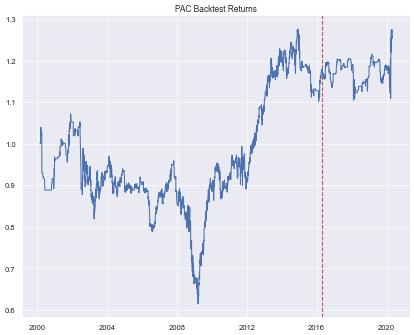

------------------------------------------------
Now working on Ridge.
CV_Score:  0.5164229401770397
Test_AUC:  0.5057430240103828


<Figure size 432x288 with 0 Axes>

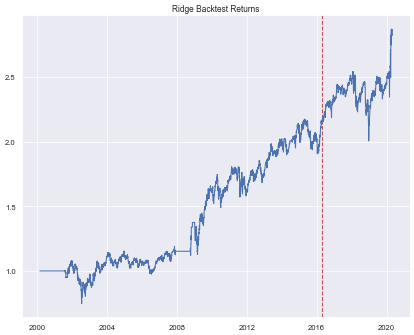

------------------------------------------------
Now working on SGD.
CV_Score:  0.5384255908423917
Test_AUC:  0.5089471122647632


<Figure size 432x288 with 0 Axes>

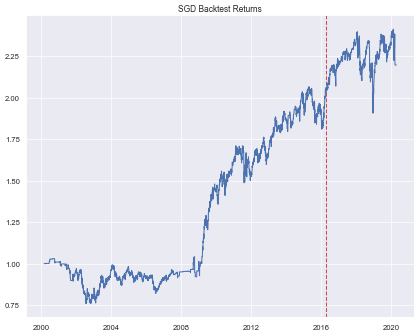

------------------------------------------------
Now working on Logistic Regression.
CV_Score:  0.5168403382892064
Test_AUC:  0.4995214146658014


<Figure size 432x288 with 0 Axes>

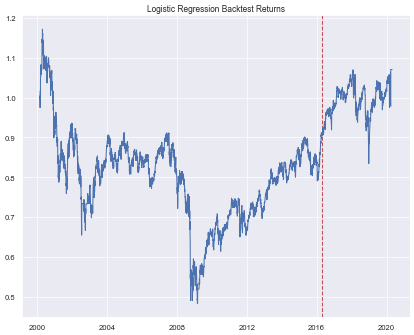

------------------------------------------------
Now working on LDA.
CV_Score:  0.5126780646941451
Test_AUC:  0.500770603504218


<Figure size 432x288 with 0 Axes>

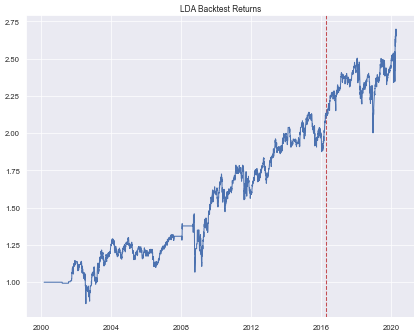

------------------------------------------------
Now working on Random Forest.
CV_Score:  0.5247251460420655
Test_AUC:  0.5045587280986372


<Figure size 432x288 with 0 Axes>

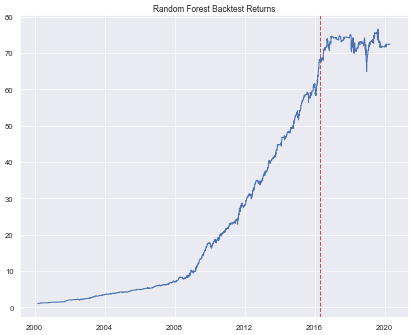

------------------------------------------------
Now working on DTC.
CV_Score:  0.5305727268645756
Test_AUC:  0.4885058403634004


<Figure size 432x288 with 0 Axes>

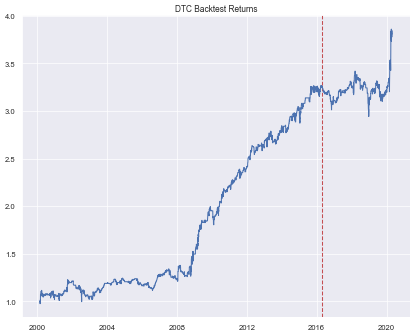

------------------------------------------------
Now working on ETC.
CV_Score:  0.5305030793656846
Test_AUC:  0.4881408176508761


<Figure size 432x288 with 0 Axes>

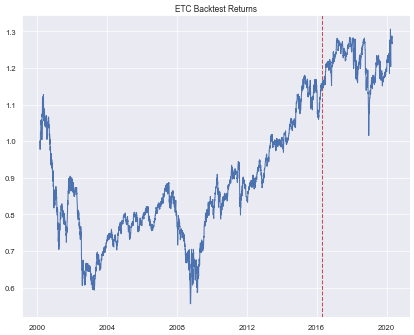

------------------------------------------------
Now working on AdaBoost.
CV_Score:  0.5335612354454029
Test_AUC:  0.4838092147955873


<Figure size 432x288 with 0 Axes>

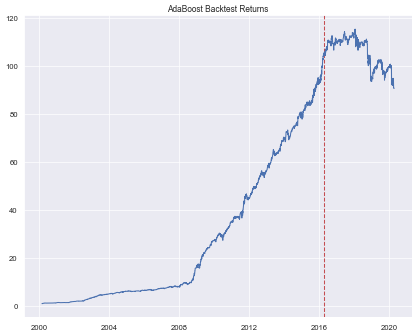

------------------------------------------------
Now working on Extra Trees Ensemble.
CV_Score:  0.5218303060208381
Test_AUC:  0.49532770927968856


<Figure size 432x288 with 0 Axes>

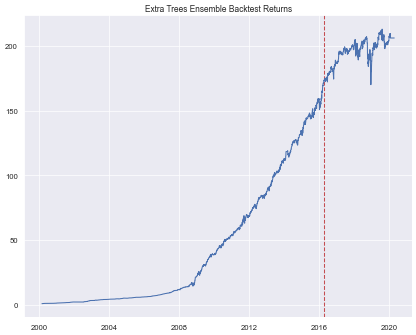

------------------------------------------------
Now working on Gradient Boosting.
CV_Score:  0.5466757313155097
Test_AUC:  0.5001541207008436


<Figure size 432x288 with 0 Axes>

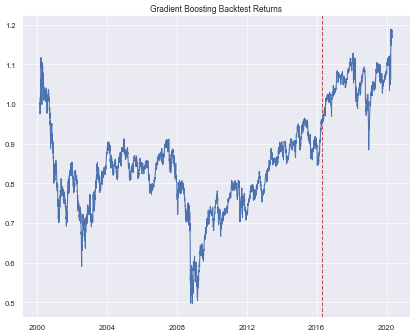

------------------------------------------------
Now working on LSVC.
CV_Score:  0.5284812199951429
Test_AUC:  0.5053942245295262


<Figure size 432x288 with 0 Axes>

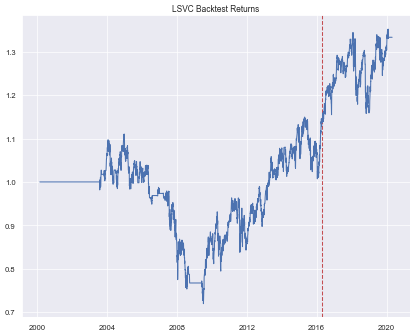

------------------------------------------------


<Figure size 432x288 with 0 Axes>

In [89]:
# Tune and evaluate classifiers
np.random.seed(1)

for clf_label, clf in classifiers.items():
    # Print message to user
    print(f"Now working on {clf_label}.")
    
    #Define cross validation split method, scoring metric, total variance to keep for PCA, and parameter grid for optimization
    split = TimeSeriesSplit(n_splits=10)
    score = 'roc_auc'
    totalVariance = 0.99
    param_grid = parameters[clf_label]

    
    # 1. Feature Selection: RFECV with clf as the base estimator
    selector = RFECV(estimator = clf,step=1, cv = split, scoring=score,n_jobs= -1)    
    selector.fit(X_train_corr,y_train.values.ravel())
    X_train_RFECV = selector.transform(X_train_corr)
    X_test_RFECV = selector.transform(X_test_corr)
    
    # 2. Dimension Reduction: PCA
    pca = PCA(totalVariance, svd_solver = 'full').fit(X_train_RFECV)
    X_train_PCA = pca.transform(X_train_RFECV)
    X_test_PCA = pca.transform(X_test_RFECV)
    
    df_results['Num_Features'][clf_label] = pca.n_components_
    # 3. Hyper-parameter Optimization
    GSCV = GridSearchCV(clf,
                        param_grid,
                        cv = split,  
                        n_jobs= -1,
                        scoring = score)
    # 4. Fit Model
    GSCV.fit(X_train_PCA, y_train.values.ravel())
    
    # Update classifier parameters
    best_params = GSCV.best_params_
    clf.set_params(**best_params)
    
    # Update performance metrics
    df_results = record_performance(df_results,clf_label,GSCV,X_train_PCA,X_test_PCA,y_train,y_test)
    df_results = simple_backtest(df_results,clf_label,GSCV,X_train_raw,X_test_raw,y_train,y_test)
                                
    # Update feature selection
    df_fs[clf_label]['RFECV'] = selector
    df_fs[clf_label]['PCA'] = pca
    
    print("------------------------------------------------")

In [90]:
df_results.to_csv("results.csv")
df_results

,Num_Features,CV_Score,Train_Accuracy,Test_Accuracy,Train_Precision,Test_Precision,Train_Recall,Test_Recall,Train_F1_Score,Test_F1_Score,Train_AUC,Test_AUC,Train_Mu,Test_Mu,Train_Sigma,Test_Sigma,Train_Sharpe,Test_Sharpe
PAC,95,0.532837,0.526355,0.481928,0.543731,0.529412,0.603828,0.335821,0.572206,0.410959,0.522347,0.493997,0.0165513,0.0202783,0.11094,0.0884967,0.149191,0.229142
Ridge,7,0.516423,0.538906,0.543173,0.538697,0.541033,0.842584,0.996269,0.657212,0.701248,0.523193,0.505743,0.0572934,0.0756645,0.130685,0.120578,0.438409,0.627516
SGD,25,0.538426,0.54242,0.539157,0.5453,0.543113,0.7689,0.904851,0.638078,0.678796,0.530701,0.508947,0.0522226,0.023695,0.115865,0.11409,0.45072,0.207688
Logistic Regression,2,0.51684,0.527359,0.536145,0.526988,0.53791,0.966986,0.979478,0.682194,0.694444,0.504612,0.499521,0.00654539,0.0486862,0.15853,0.119459,0.0412879,0.407556
LDA,13,0.512678,0.540914,0.538153,0.542633,0.53854,0.794737,0.990672,0.644923,0.697766,0.52778,0.500771,0.0566706,0.0641966,0.133281,0.12258,0.425196,0.523714
Random Forest,286,0.524725,0.661647,0.491968,0.682399,0.54491,0.664115,0.339552,0.673133,0.418391,0.661519,0.504559,0.273099,0.0180855,0.107742,0.0745206,2.53475,0.242691
DTC,38,0.530573,0.546436,0.488956,0.592062,0.526839,0.435407,0.494403,0.501792,0.510106,0.552181,0.488506,0.0799365,0.0413691,0.101227,0.0898668,0.789674,0.460338
ETC,77,0.530503,0.522088,0.52008,0.527911,0.531729,0.841627,0.906716,0.648838,0.670345,0.505555,0.488141,0.0198141,0.0303332,0.146529,0.111705,0.135223,0.271547
AdaBoost,17,0.533561,0.648092,0.498996,0.632206,0.526619,0.787081,0.682836,0.701194,0.594639,0.640901,0.483809,0.302664,-0.0334337,0.12485,0.0936091,2.42422,-0.357163
Extra Trees Ensemble,280,0.52183,0.676205,0.513052,0.697044,0.534979,0.677033,0.727612,0.686893,0.616601,0.676162,0.495328,0.332939,0.0480229,0.113513,0.0928383,2.93306,0.517275


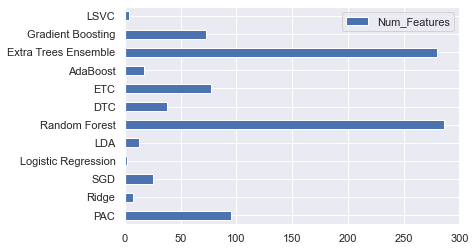

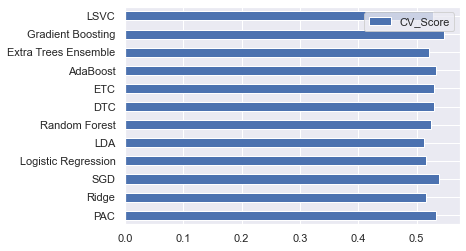

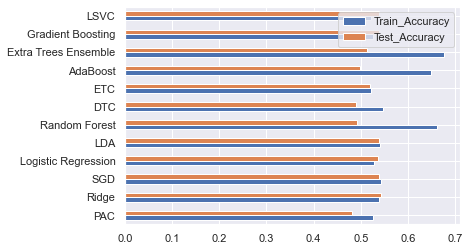

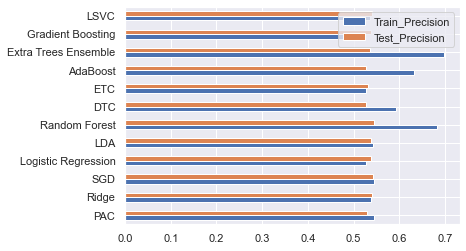

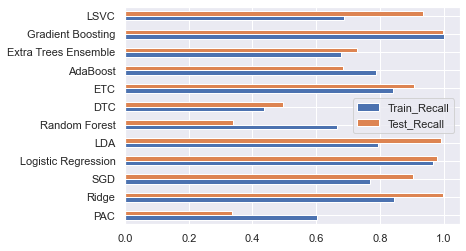

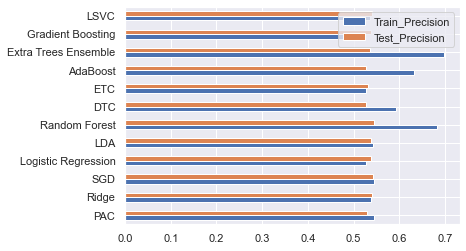

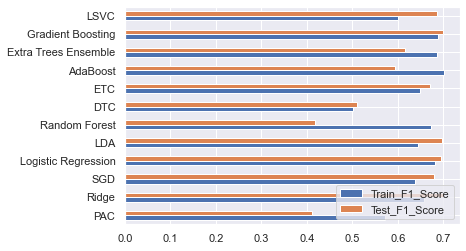

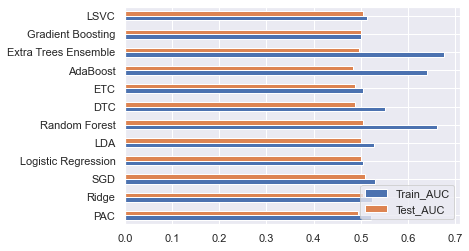

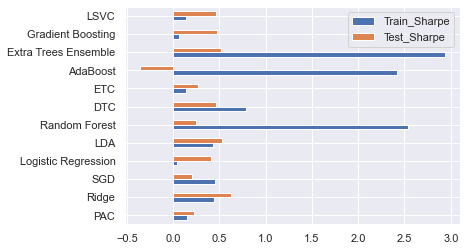

In [91]:
# Visualize the results
df_results.plot.barh(y='Num_Features')
df_results.plot.barh(y='CV_Score')
df_results[['Train_Accuracy','Test_Accuracy']].plot.barh()
df_results[['Train_Precision','Test_Precision']].plot.barh()
df_results[['Train_Recall','Test_Recall']].plot.barh()
df_results[['Train_Precision','Test_Precision']].plot.barh()
df_results[['Train_F1_Score','Test_F1_Score']].plot.barh()
df_results[['Train_AUC','Test_AUC']].plot.barh()
df_results[['Train_Sharpe','Test_Sharpe']].plot.barh()

### Model Insights - Feature Selection
Ridge Regression and LDA both had interesting results out-of-sample. What are the features that are driving the model?

***********************************************
Model:  Ridge


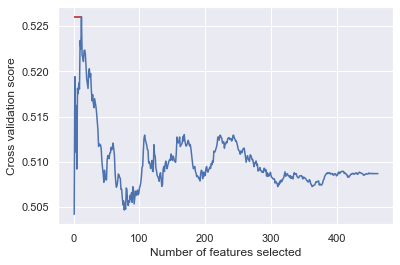

Number of features selected by RFECV
12
Feature ranking and their importances:


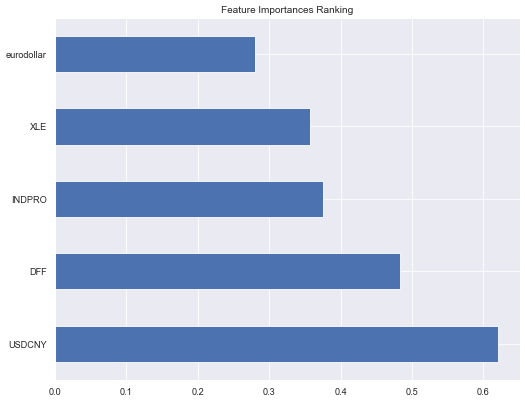

Number of principal components selected by PCA
7
***********************************************
Model:  LDA


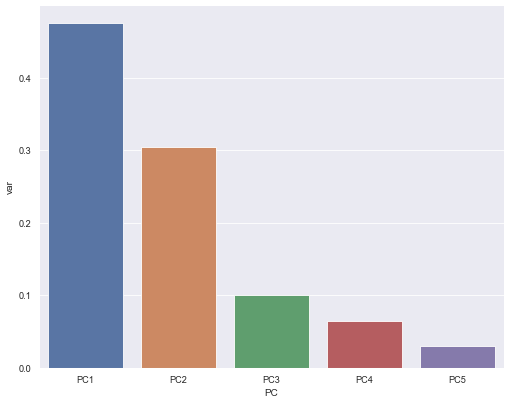

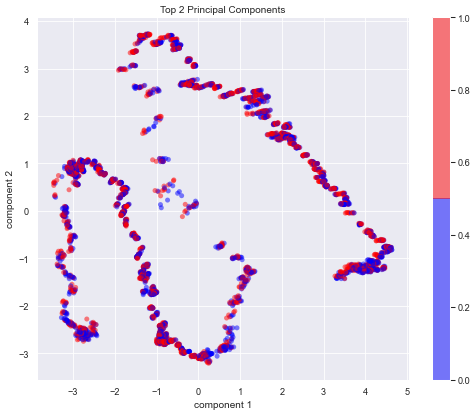

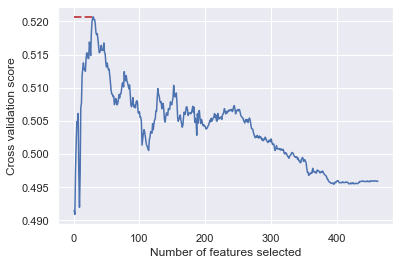

Number of features selected by RFECV
30
Feature ranking and their importances:


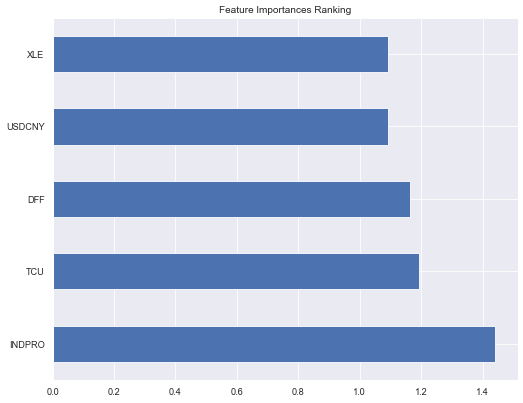

Number of principal components selected by PCA
13
***********************************************
Model:  PAC


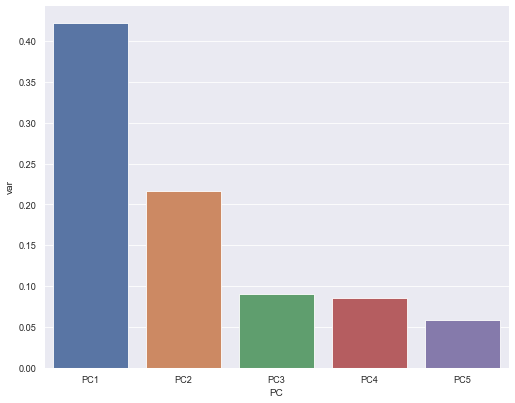

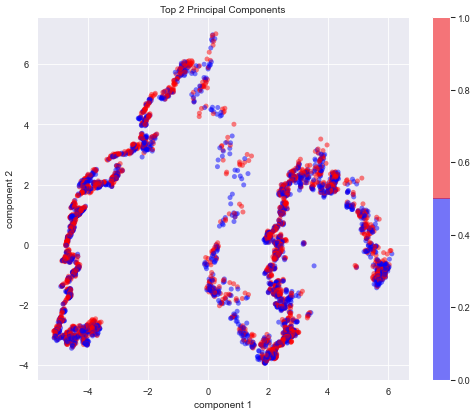

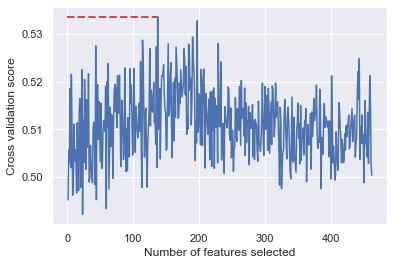

Number of features selected by RFECV
137
Feature ranking and their importances:


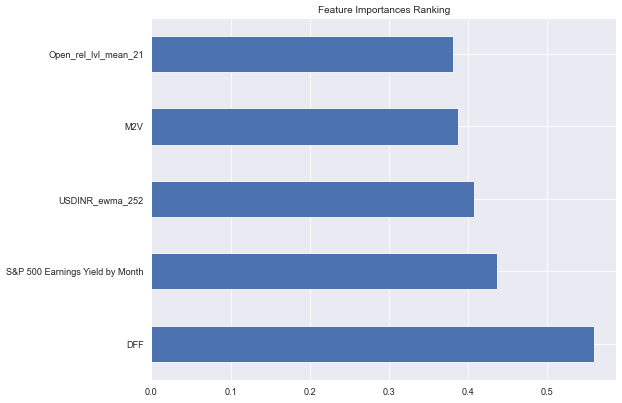

Number of principal components selected by PCA
95


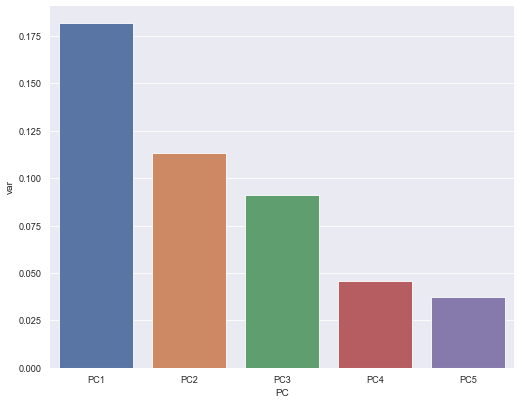

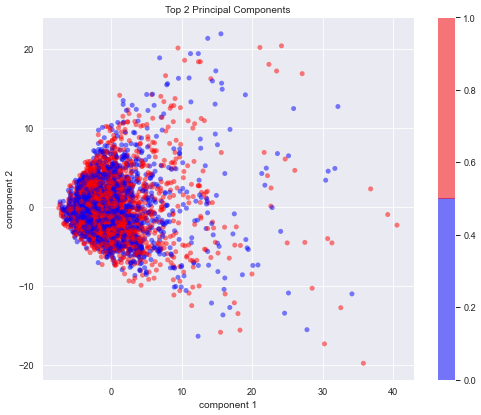

In [192]:
np.random.seed(1)

models_to_check = ["Ridge","LDA","PAC"]
for clf_label in models_to_check:
    print("***********************************************")
    print("Model: ", clf_label)
    selector = df_fs[clf_label]['RFECV'] 
    pca = df_fs[clf_label]['PCA'] 
    
    X_train_RFECV = selector.transform(X_train_corr)
    X_test_RFECV = selector.transform(X_test_corr)
    
    X_train_PCA = pca.transform(X_train_RFECV)
    X_test_PCA = pca.transform(X_test_RFECV)

    rfecv_analysis_viz(selector)
    feature_importance_viz(selector,X_train_corr,X_train_RFECV)
    pca_component_viz(pca,X_train_PCA)


***********************************************
Model:  Ridge


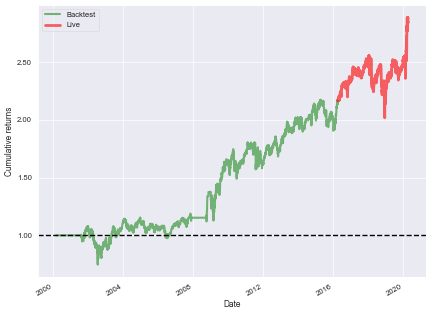

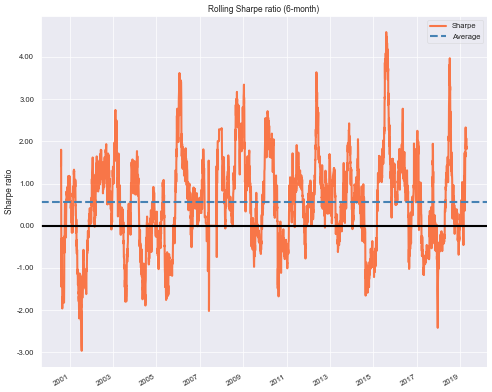

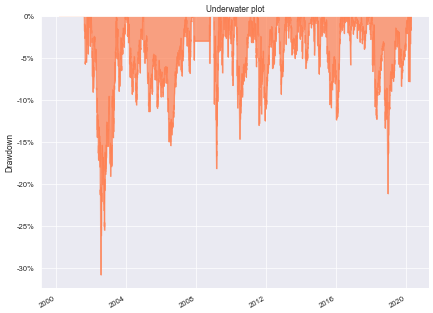

Stress Events,mean,min,max
Lehman,0.00%,0.00%,0.00%
EZB IR Event,-0.08%,-1.27%,1.54%
Flash Crash,-0.78%,-2.86%,0.66%
Apr14,-0.12%,-2.10%,0.80%
GFC Crash,0.04%,-4.63%,7.35%


***********************************************
Model:  LDA


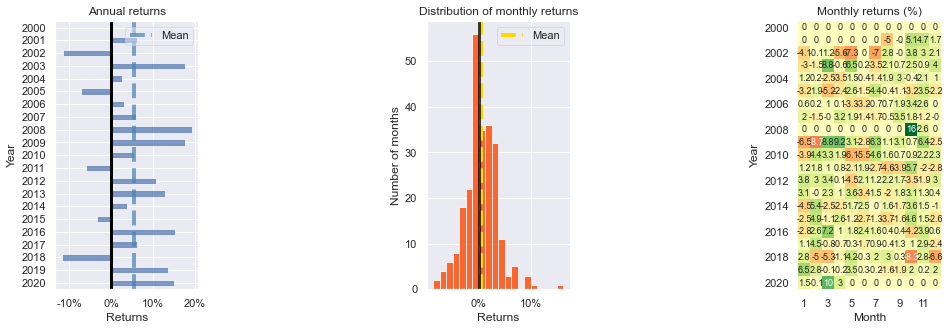

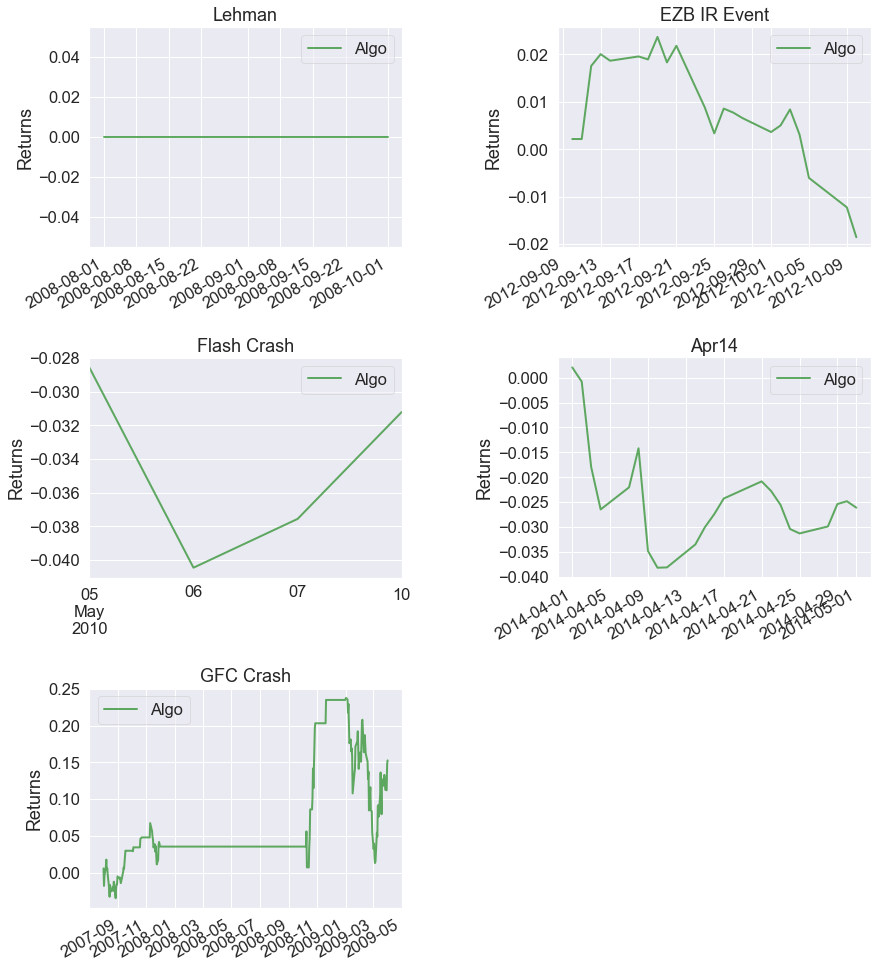

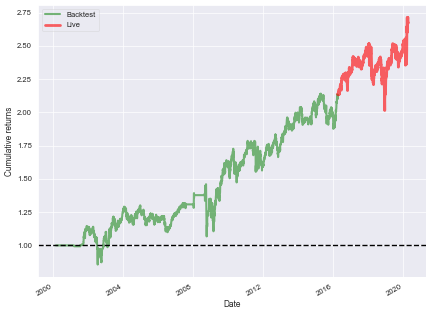

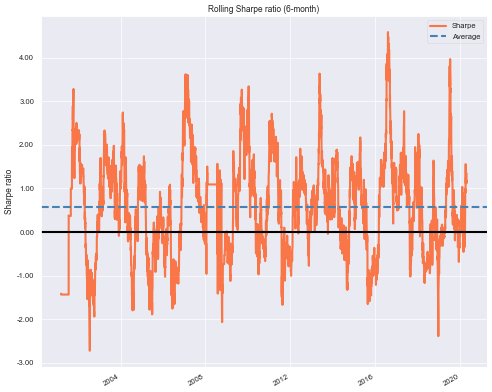

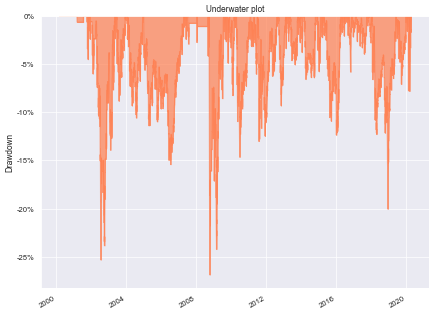

Stress Events,mean,min,max
Lehman,0.14%,-3.05%,4.17%
EZB IR Event,-0.08%,-1.27%,1.54%
Flash Crash,-0.78%,-2.86%,0.66%
Apr14,-0.13%,-2.10%,0.80%
GFC Crash,0.00%,-8.99%,7.35%


***********************************************
Model:  PAC


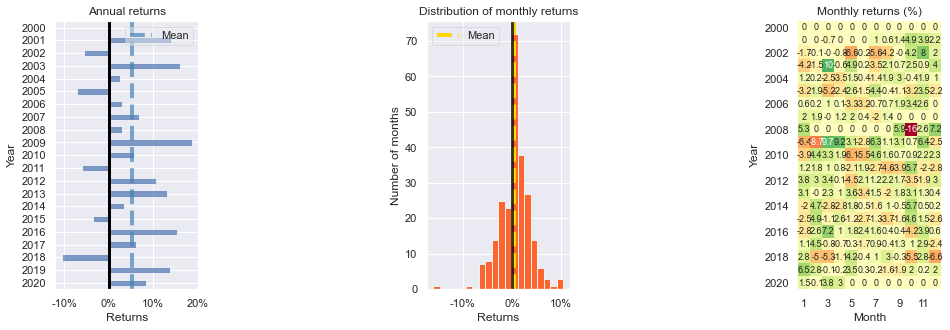

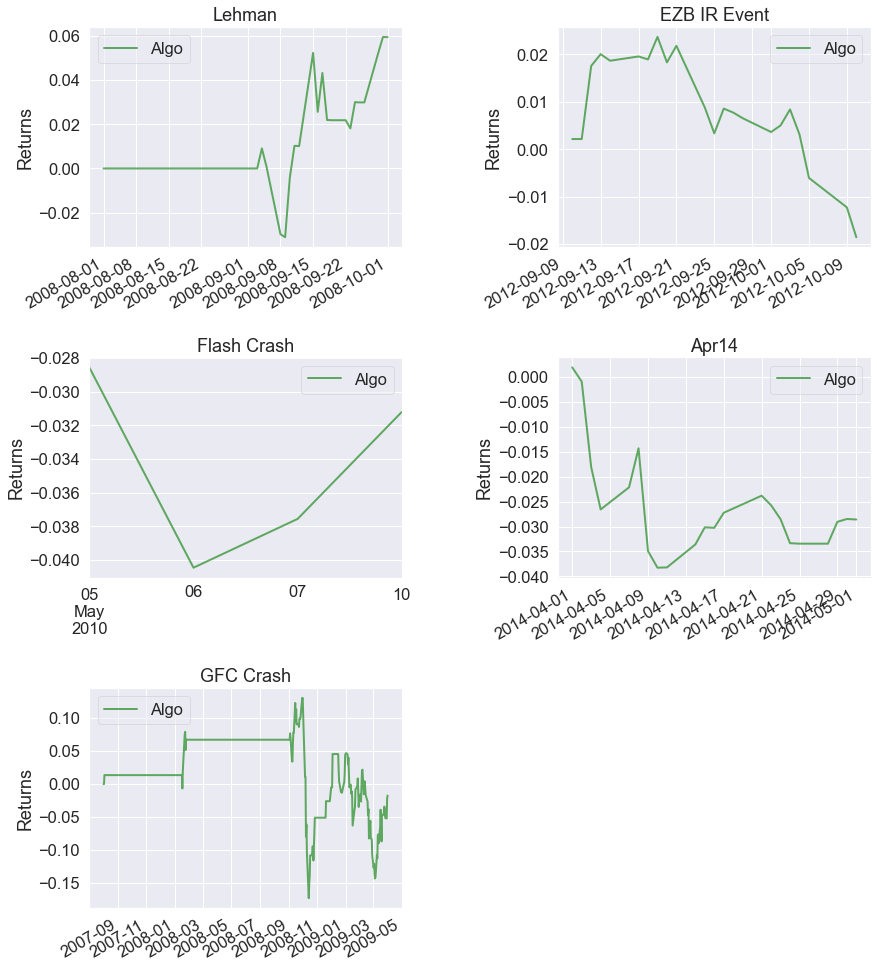

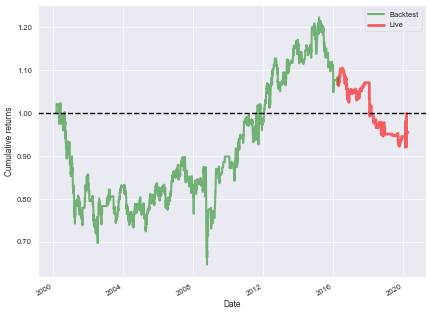

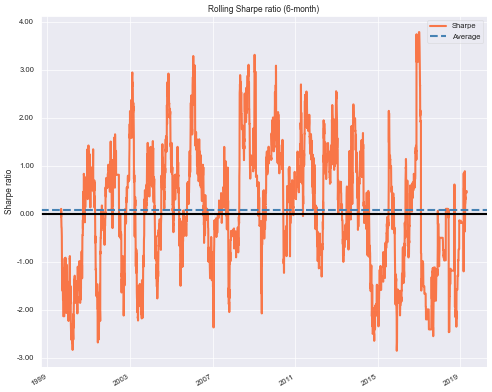

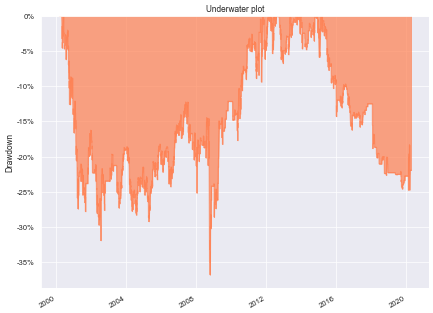

Stress Events,mean,min,max
Lehman,0.03%,-6.52%,4.18%
EZB IR Event,-0.06%,-0.64%,0.00%
Flash Crash,-0.72%,-2.86%,0.00%
Apr14,-0.02%,-0.50%,0.45%
GFC Crash,-0.01%,-8.99%,7.35%


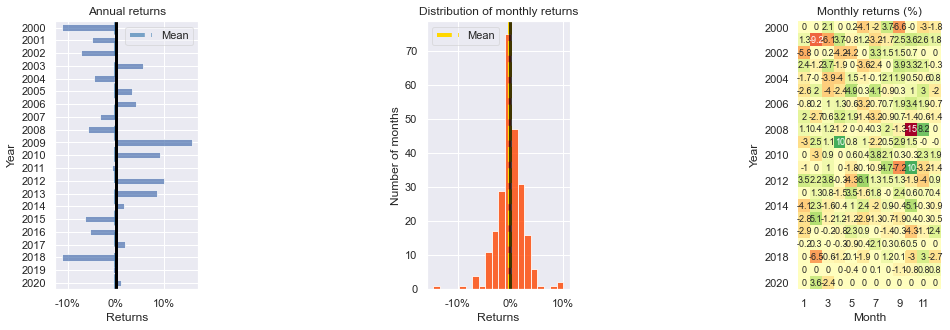

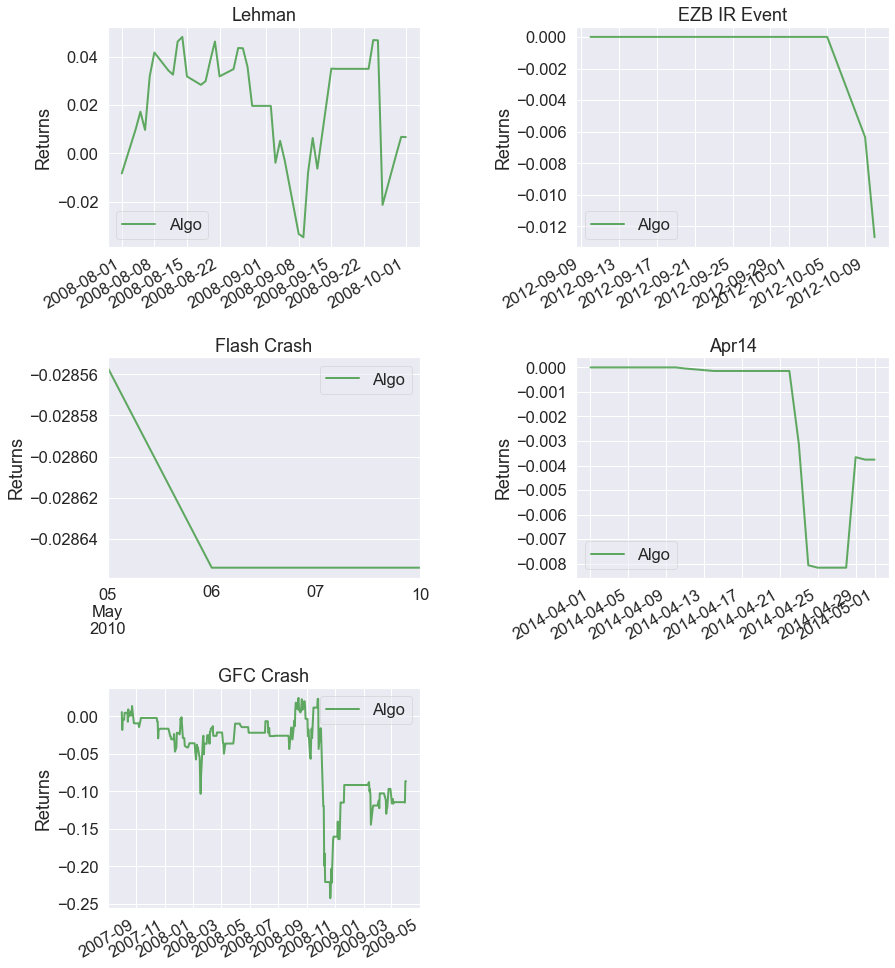

In [188]:
np.random.seed(1)

models_to_check = ["Ridge","LDA","PAC"]
for clf_label in models_to_check:
    print("***********************************************")
    print("Model: ", clf_label)
    selector = df_fs[clf_label]['RFECV'] 
    pca = df_fs[clf_label]['PCA']
    
    clf = classifiers[clf_label]
    
    X_train_RFECV = selector.transform(X_train_corr)
    X_test_RFECV = selector.transform(X_test_corr)
    
    X_train_PCA = pca.transform(X_train_RFECV)
    X_test_PCA = pca.transform(X_test_RFECV)
    
    clf.fit(X_train_PCA, y_train.values.ravel())
    
    y_pred_IS = clf.predict(X_train_PCA)
    y_pred_OOS = clf.predict(X_test_PCA)
    
    #Quick backtest function to plot the hypothetical returns in IS and OOS.
    df_train = pd.DataFrame(index=y_train.index)
    df_train['Signals'] = y_pred_IS
    
    df_test = pd.DataFrame(index=y_test.index)
    df_test['Signals'] = y_pred_OOS
    
    df_train['Open'] = X_train_raw['Open']
    df_train['Close'] = X_train_raw['Close']
 
    df_test['Open'] = X_test_raw['Open']
    df_test['Close'] =  X_test_raw['Close']
    
    frames = [df_train,df_test]
    df_backtest = pd.concat(frames)
    
    df_backtest['Forward_ret'] = df_backtest['Close'].shift(-1)/df_backtest['Open'].shift(-1) -1
    df_backtest['Costs'] = abs(df_backtest['Signals'] - df_backtest['Signals'].shift(1))*cost
    df_backtest['Strategy_forward_ret'] = df_backtest['Forward_ret'] *df_backtest['Signals']-df_backtest['Costs']
    
    bt_returns = df_backtest['Strategy_forward_ret']
    
    plt.figure(figsize=(10, 8), dpi= 50)
    # Cumulative Returns
    pf.plotting.plot_rolling_returns(bt_returns,live_start_date = df_test.index[0])
    plt.show()
    
    # Daily, Non-Cumulative Returns
    plt.figure(figsize=(10, 8), dpi= 50)
    pf.plot_rolling_sharpe(bt_returns)
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(10, 8), dpi= 50)
    pf.plot_drawdown_underwater(bt_returns);
    plt.show()
        
    fig = plt.figure(1)
    plt.subplot(1,3,1)
    pf.plot_annual_returns(bt_returns)
    plt.subplot(1,3,2)
    pf.plot_monthly_returns_dist(bt_returns)
    plt.subplot(1,3,3)
    pf.plot_monthly_returns_heatmap(bt_returns)
    plt.tight_layout()
    fig.set_size_inches(15,5)
    
    pf.create_interesting_times_tear_sheet(bt_returns)